### <center>notMNIST_small</center>

Using __[Keras](https://keras.io/)__ for `notMNIST_small` data set.

In [10]:
import os, glob, random, pickle, gc

import numpy as np
import pandas as pd

from PIL import Image

from keras.utils import to_categorical, plot_model
from keras import backend as K
from keras import regularizers

from keras.preprocessing.image import ImageDataGenerator

from keras.models import Model, Sequential, load_model
from keras.layers import (Input, Dense, Activation, Conv2D, 
                          MaxPooling2D, BatchNormalization, Dropout, 
                          Flatten, Concatenate, Average)

from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use(['seaborn-darkgrid'])
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

The dataset could be found __[here](https://www.kaggle.com/jwjohnson314/notmnist)__.

The dataset was downloaded and saved to root directory.

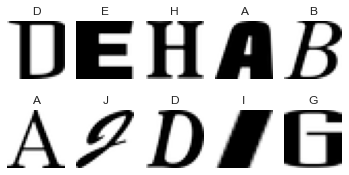

In [2]:
im_root = 'notMNIST_small'

dirs = os.listdir(im_root)
fig, ax = plt.subplots(2, 5, figsize=(6, 3))

for i in range(2):
    for j in range(5):
        dr = random.choice(dirs)
        im = random.choice(os.listdir(os.path.join(im_root, dr)))
        ax[i, j].imshow(plt.imread(os.path.join(im_root, dr, im)))
        ax[i, j].set_title(dr)
        ax[i, j].axis('off')
pass;

In [3]:
print(f'{len(dirs)} directories contain letters: {dirs}')

10 directories contain letters: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']


In [4]:
im_view = Image.open(im_root + '/' + random.choice(dirs) + '/' + 
                     random.choice(os.listdir(os.path.join(im_root, dr))))
im_view
print(f'Image size {im_view.size}')

Image size (28, 28)


In [41]:
_, img_size = im_view.size

In [164]:
%%time
data = []
for letter in dirs:
    for image in os.listdir(im_root + '/' + letter):
        try:
            file_path = im_root + '/' + letter + '/' + image
            img = Image.open(file_path)
            img.load()
            img_data = np.asarray(img)           
            idx = dirs.index(letter)
            data.append([img_data, idx])
        except Exception as ex:
            print(ex)
pass;

cannot identify image file 'notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png'
cannot identify image file 'notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png'
Wall time: 9.56 s


In [165]:
def myfunction():
    return 0.5
random.shuffle(data, myfunction)

In [166]:
X = []
y = []
for img_data, idx in data:
    X.append(img_data)
    y.append(idx)

In [168]:
# Number of images of each letter
unique, counts = np.unique(y, return_counts=True)
print(np.asarray((unique, counts)))

[[   0    1    2    3    4    5    6    7    8    9]
 [1872 1873 1873 1873 1873 1872 1872 1872 1872 1872]]


In [72]:
num_classes = len(set(y))
num_classes

10

In [73]:
X = np.array(X).reshape(-1, img_size, img_size, 1) / 255.
y = to_categorical(y, num_classes=10)

In [74]:
y[1]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [75]:
X.shape
y.shape

(18724, 28, 28, 1)

(18724, 10)

In [76]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42)

In [77]:
X_train.shape
X_test.shape
X_val.shape

(13481, 28, 28, 1)

(3745, 28, 28, 1)

(1498, 28, 28, 1)

In [6]:
input_shape = X_train[0].shape

In [7]:
input_shape

(28, 28, 1)

In [8]:
gc.collect()

0

#### Callbacks <a id="2"></a>

In [9]:
early_stop = EarlyStopping('val_accuracy', patience=30, verbose=1)

reduce_lr = ReduceLROnPlateau(
    factor=0.1, patience=5, min_lr=0.00001, verbose=1)

### Sequential API<a id="3"></a>

#### Model 1. `2x64Conv2D_Dense256`<a id="3.1"></a>

In [83]:
cnn_model = Sequential()

cnn_model.add(Conv2D(64, 3, padding='same', input_shape=input_shape))
cnn_model.add(Activation('relu'))
cnn_model.add(BatchNormalization())

cnn_model.add(Conv2D(64, 3, padding='same'))
cnn_model.add(Activation('relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(.25))

cnn_model.add(Flatten())
cnn_model.add(Dense(256))
cnn_model.add(Activation('relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(.5))
cnn_model.add(Dense(10))
cnn_model.add(Activation('softmax'))

cnn_model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(lr=.01),
    metrics=['accuracy'])

In [85]:
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 64)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
activation_2 (Activation)    (None, 28, 28, 64)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 64)       

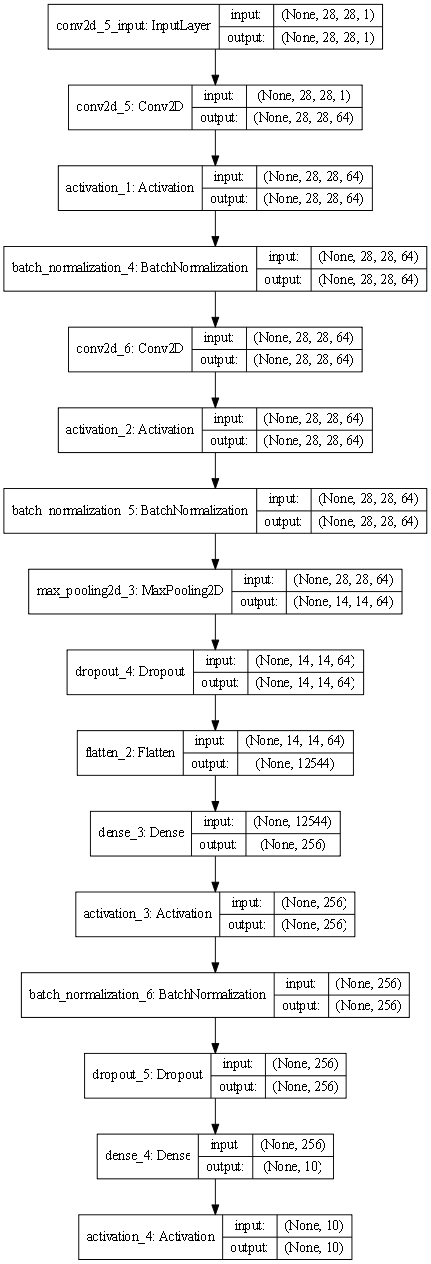

In [109]:
plot_model(cnn_model, 'plots/cnn_model.png', 
           show_shapes=True, dpi=70)

In [ ]:
model_checkpoint_cnn = ModelCheckpoint(
    'models/cnn_model.h5', 'val_accuracy', save_best_only=True, verbose=1)

In [ ]:
batch_size = 64
epochs = 100

In [89]:
history = cnn_model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_val, y_val),
    callbacks=[model_checkpoint_cnn, early_stop, reduce_lr])

Train on 13481 samples, validate on 1498 samples
Epoch 1/100
13481/13481 [==============================] - 55s 4ms/step - loss: 0.5358 - accuracy: 0.8531 - val_loss: 6.6982 - val_accuracy: 0.0895

Epoch 00001: val_accuracy improved from -inf to 0.08945, saving model to models/cnn_model.h5
Epoch 2/100
13481/13481 [==============================] - 53s 4ms/step - loss: 0.2903 - accuracy: 0.9162 - val_loss: 0.7192 - val_accuracy: 0.7764

Epoch 00002: val_accuracy improved from 0.08945 to 0.77637, saving model to models/cnn_model.h5
Epoch 3/100
13481/13481 [==============================] - 53s 4ms/step - loss: 0.2408 - accuracy: 0.9298 - val_loss: 0.2725 - val_accuracy: 0.9219

Epoch 00003: val_accuracy improved from 0.77637 to 0.92190, saving model to models/cnn_model.h5
Epoch 4/100
13481/13481 [==============================] - 53s 4ms/step - loss: 0.1909 - accuracy: 0.9415 - val_loss: 0.2448 - val_accuracy: 0.9372

Epoch 00004: val_accuracy improved from 0.92190 to 0.93725, saving mod

In [360]:
score_cnn = cnn_model.evaluate(X_test, y_test, verbose=0)
print("\nTest score:", round(score_cnn[0], 4))
print('Test accuracy:', round(score_cnn[1], 4))


Test score: 0.1894
Test accuracy: 0.9557


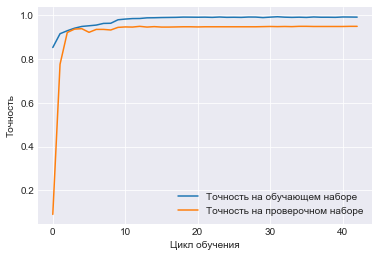

In [91]:
plt.plot(history.history['accuracy'], label='Точность на обучающем наборе')
plt.plot(
    history.history['val_accuracy'], label='Точность на проверочном наборе')
plt.xlabel('Цикл обучения')
plt.ylabel('Точность')
plt.legend()
plt.show()
pass;

In [313]:
pred_cnn = cnn_model.predict(X_test, verbose=0)

y_pred_cnn = np.argmax(pred_cnn, axis=-1)
y_test_rev = np.argmax(y_test, axis=1)

In [314]:
confusion_matrix(y_test_rev, y_pred_cnn)

array([[357,   0,   0,   4,   0,   0,   0,   0,   3,   3],
       [  1, 360,   1,   1,   5,   2,   5,   0,   1,   1],
       [  0,   1, 350,   1,   5,   0,   9,   0,   2,   1],
       [  1,   2,   2, 363,   0,   2,   1,   0,   0,   4],
       [  0,   2,   2,   0, 358,   2,   5,   0,   3,   1],
       [  2,   0,   0,   0,   7, 350,   1,   1,   3,   3],
       [  3,   3,   9,   0,   2,   4, 369,   1,   1,   2],
       [  4,   2,   0,   2,   0,   1,   1, 335,   1,   0],
       [  5,   1,   3,   0,   4,   0,   0,   0, 387,  12],
       [  0,   0,   0,   3,   0,   0,   0,   2,  10, 350]], dtype=int64)

In [315]:
print(classification_report(y_test_rev, y_pred_cnn))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       367
           1       0.97      0.95      0.96       377
           2       0.95      0.95      0.95       369
           3       0.97      0.97      0.97       375
           4       0.94      0.96      0.95       373
           5       0.97      0.95      0.96       367
           6       0.94      0.94      0.94       394
           7       0.99      0.97      0.98       346
           8       0.94      0.94      0.94       412
           9       0.93      0.96      0.94       365

    accuracy                           0.96      3745
   macro avg       0.96      0.96      0.96      3745
weighted avg       0.96      0.96      0.96      3745



### Keras Functional API<a id="4"></a>

In [ ]:
aug = ImageDataGenerator(rotation_range=10, 
                         width_shift_range=0.1,
                         height_shift_range=0.1)

#### Model 2. `4x64Conv2D_Dense1024_aug_reg`<a id="4.1"></a>

In [25]:
def doc_aug_init(input_shape, num_classes, loss='categorical_crossentropy'):

    inp = Input(name='input', shape=input_shape)

    x = Conv2D(64, 3,
        padding="same",
        activation='relu',
        kernel_initializer='he_uniform')(inp)    
    x = Conv2D(64, 3,
        padding="same",
        activation='relu',
        kernel_initializer='he_uniform',
        kernel_regularizer=regularizers.l2(0.0001))(x)
    
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(.25)(x)

    x = Conv2D(64, 3,
        padding="same",
        activation='relu',
        kernel_initializer='he_uniform')(x)    
    x = Conv2D(64 3,
        padding="same",
        activation='relu',
        kernel_initializer='he_uniform',
        kernel_regularizer=regularizers.l2(0.0001))(x)
    
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(.25)(x)

    x = Flatten()(x)
    x = Dense(1024,
        activation='relu',
        kernel_initializer='he_uniform',
        kernel_regularizer=regularizers.l2(0.0001))(x)
    x = BatchNormalization()(x)
    x = Dropout(.4)(x)
    out = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inp, outputs=out, name='doc_aug_init')
    model.compile(loss=loss, optimizer=Adam(lr=.01), metrics=['accuracy'])

    return model

In [27]:
doc_init_model = doc_aug_init(input_shape=input_shape, num_classes=num_classes)

In [28]:
doc_init_model.summary()

Model: "doc_aug_init"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
batch_normalization_4 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 64)       

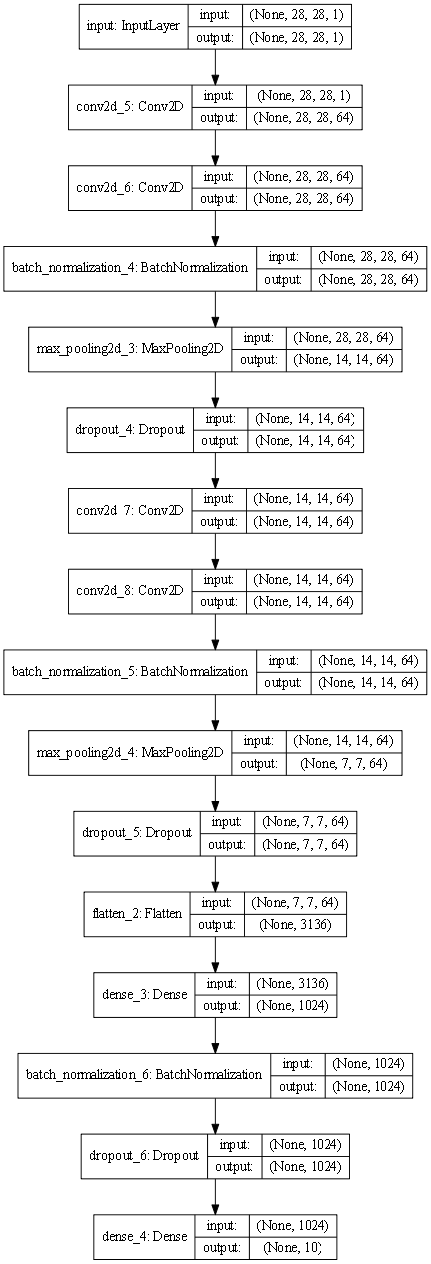

In [29]:
plot_model(
    doc_init_model, 'plots/doc_init_model.png', show_shapes=True, dpi=70)

In [30]:
model_checkpoint_doc_init = ModelCheckpoint(
    'models/doc_init_model.h5', 'val_accuracy', save_best_only=True, verbose=1)

In [31]:
history_doc_init = doc_init_model.fit_generator(
    aug.flow(X_train, y_train, batch_size=batch_size),
    validation_data=[X_val, y_val],
    epochs=epochs,
    verbose=1,
    callbacks=[model_checkpoint_doc_init, early_stop, reduce_lr])

Epoch 1/100
211/211 [==============================] - 55s 259ms/step - loss: 2.2595 - accuracy: 0.8011 - val_loss: 3.2912 - val_accuracy: 0.7497

Epoch 00001: val_accuracy improved from -inf to 0.74967, saving model to models/doc_init_model.h5
Epoch 2/100
211/211 [==============================] - 56s 267ms/step - loss: 1.7867 - accuracy: 0.8636 - val_loss: 1.5355 - val_accuracy: 0.9005

Epoch 00002: val_accuracy improved from 0.74967 to 0.90053, saving model to models/doc_init_model.h5
Epoch 3/100
211/211 [==============================] - 62s 295ms/step - loss: 1.4735 - accuracy: 0.8737 - val_loss: 1.3094 - val_accuracy: 0.9052

Epoch 00003: val_accuracy improved from 0.90053 to 0.90521, saving model to models/doc_init_model.h5
Epoch 4/100
211/211 [==============================] - 62s 296ms/step - loss: 1.1742 - accuracy: 0.8905 - val_loss: 1.0482 - val_accuracy: 0.9079

Epoch 00004: val_accuracy improved from 0.90521 to 0.90788, saving model to models/doc_init_model.h5
Epoch 5/100

211/211 [==============================] - 50s 238ms/step - loss: 0.2662 - accuracy: 0.9561 - val_loss: 0.2889 - val_accuracy: 0.9546

Epoch 00039: val_accuracy did not improve from 0.95594
Epoch 40/100
211/211 [==============================] - 50s 238ms/step - loss: 0.2637 - accuracy: 0.9573 - val_loss: 0.2821 - val_accuracy: 0.9566

Epoch 00040: val_accuracy improved from 0.95594 to 0.95661, saving model to models/doc_init_model.h5
Epoch 41/100
211/211 [==============================] - 50s 238ms/step - loss: 0.2580 - accuracy: 0.9598 - val_loss: 0.3064 - val_accuracy: 0.9566

Epoch 00041: val_accuracy did not improve from 0.95661
Epoch 42/100
211/211 [==============================] - 50s 237ms/step - loss: 0.2524 - accuracy: 0.9612 - val_loss: 0.3045 - val_accuracy: 0.9513

Epoch 00042: val_accuracy did not improve from 0.95661
Epoch 43/100
211/211 [==============================] - 50s 238ms/step - loss: 0.2498 - accuracy: 0.9594 - val_loss: 0.3080 - val_accuracy: 0.9533

Epoch 0

211/211 [==============================] - 50s 238ms/step - loss: 0.1713 - accuracy: 0.9757 - val_loss: 0.2618 - val_accuracy: 0.9593

Epoch 00078: val_accuracy did not improve from 0.96128
Epoch 00078: early stopping


In [362]:
score_doc_init = doc_init_model.evaluate(X_test, y_test, verbose=0)
print("\nTest score:", round(score_doc_init[0], 4))
print('Test accuracy:', round(score_doc_init[1], 4))


Test score: 0.2365
Test accuracy: 0.9696


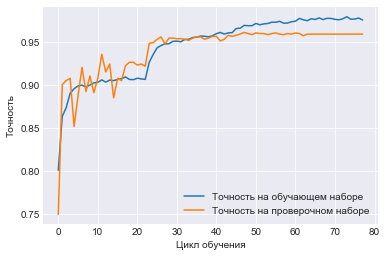

In [33]:
plt.plot(
    history_doc_init.history['accuracy'], label='Точность на обучающем наборе')
plt.plot(
    history_doc_init.history['val_accuracy'],
    label='Точность на проверочном наборе')
plt.xlabel('Цикл обучения')
plt.ylabel('Точность')
plt.legend()
plt.show()
pass;

In [317]:
pred_doc_init = doc_init_model.predict(X_test, verbose=0)
y_pred_doc_init = np.argmax(pred_doc_init, axis=-1)

In [318]:
confusion_matrix(y_test_rev, y_pred_doc_init)

array([[360,   1,   0,   2,   1,   1,   0,   1,   1,   0],
       [  0, 368,   0,   2,   3,   0,   2,   0,   0,   2],
       [  0,   2, 351,   1,   6,   0,   9,   0,   0,   0],
       [  1,   2,   0, 369,   0,   0,   0,   0,   0,   3],
       [  0,   0,   2,   0, 364,   4,   2,   1,   0,   0],
       [  4,   1,   1,   0,   0, 358,   0,   3,   0,   0],
       [  1,   0,   2,   2,   1,   2, 384,   0,   1,   1],
       [  4,   1,   0,   0,   0,   1,   1, 338,   0,   1],
       [  3,   0,   0,   1,   3,   2,   1,   1, 392,   9],
       [  0,   1,   0,   2,   0,   3,   0,   1,  11, 347]], dtype=int64)

In [319]:
print(classification_report(y_test_rev, y_pred_doc_init))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       367
           1       0.98      0.98      0.98       377
           2       0.99      0.95      0.97       369
           3       0.97      0.98      0.98       375
           4       0.96      0.98      0.97       373
           5       0.96      0.98      0.97       367
           6       0.96      0.97      0.97       394
           7       0.98      0.98      0.98       346
           8       0.97      0.95      0.96       412
           9       0.96      0.95      0.95       365

    accuracy                           0.97      3745
   macro avg       0.97      0.97      0.97      3745
weighted avg       0.97      0.97      0.97      3745



Let's visualize some incorrectly marked letters.

In [320]:
result = pd.DataFrame({'pred': y_pred_doc_init, 'true': y_test_rev})

In [321]:
# back from numbers to letters
result.pred = result.pred.apply(lambda x: chr(ord('@')+(int(x)+1)))
result.true = result.true.apply(lambda x: chr(ord('@')+(int(x)+1)))

In [322]:
bad_pred = result[result.pred != result.true].head(15)
bad_pred

,pred,true
20,I,J
47,F,I
55,I,J
119,B,D
131,D,G
174,F,E
256,H,F
274,E,A
287,F,G
319,G,C


In [323]:
x_test_reshape = X_test.reshape(X_test.shape[0], 
                                X_test.shape[1], 
                                X_test.shape[2])

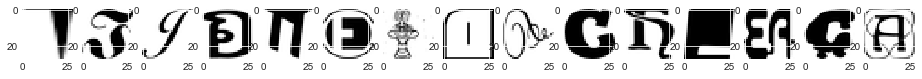

In [324]:
f, axs = plt.subplots(1, 15, figsize=(16, 20))

graphs_imgs = zip(axs, bad_pred.index.values)
for ax, i in graphs_imgs:
    ax.imshow(x_test_reshape[i, :, :])
pass;